# M1 Coursework - Questions 1 and 2

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import optuna
import json

np.random.seed(30)  

# Question 1 - Importing and Creating data

### Step 1 - Producing Initial Training, Validation and Test Datasets

- **Training Data**: For adjusting parameters based on the loss function during training.
- **Validation Data**: For fine-tune hyperparameters and preventing overfitting in training.
- **Test Data**: For evaluate the model’s performance on unseen data after training.

#### 1.1 - Immediatly shuffle data

- Although MNIST is already randomly distribution, it is good practice to shuffle data points early to ensure statistical consistency and even label distribution across training, validation, and test sets.

#### 1.2 - Split training, validation and test sets

- Splitting at this stage ensures that the training, validation, and test sets remain independent and unseen from one another during training and evaluating the performance. 

    | **Dataset**  | **Size (single-digit images)** |
    |--------------|--------------------------------|
    | Training     | 48,000                         |
    | Validation   | 12,000                         |
    | Test         | 10,000                         |

#### 1.3 - Normalise and Set Data Type

- Normalise the pixel values to be in range [0, 1] to standardise inputs for the model.  
- Convert the data type to `float32` for compatibility with packages.

#### 1.4 - Plot distributions of each to show statistical consistency 

- At this stage we look for a flat distribution over all values (0-9) within the limits of the MNIST data set





In [2]:
# Import initial data set from mnist
# x_train_val - will be split into training and validation sets
(x_train_val, y_train_val), (x_test, y_test) = mnist.load_data()

# Determine how many parameter values are in the data set
num_params = len(np.unique(y_test))

# Normalise the data
x_train_val = x_train_val / 255
x_test = x_test / 255

# Set the data type to float32
x_train_val = x_train_val.astype('float32')
x_test = x_test.astype('float32')

# Randomly shuffle data to ensure even distribution of labels
# Shuffle 60,000 data set
indices_train_val = np.arange(len(x_train_val))
np.random.shuffle(indices_train_val)
x_train_val = x_train_val[indices_train_val]
y_train_val = y_train_val[indices_train_val]

# Shuffle 10,000 data set
indices_test = np.arange(len(x_test))
np.random.shuffle(indices_test)
x_test = x_test[indices_test]
y_test = y_test[indices_test]

# Split test_val data into training and validation sets()
split_index = int(0.8 * len(x_train_val)) 
# 80 % going to training set
x_train = x_train_val[:split_index] 
y_train = y_train_val[:split_index]
# 20 % going to validation set
x_val = x_train_val[split_index:]
y_val = y_train_val[split_index:]


Item 30340/48000 from x_train
Label: 8


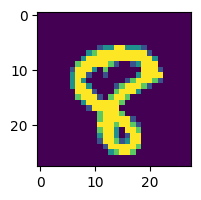

In [3]:
# Print example initial data and labels - randomly selected
plot_index = np.random.randint(0, len(x_train))
print(f"Item {plot_index}/{len(x_train)} from x_train")
print(f'Label: {y_train[plot_index]}')
plt.figure(figsize=(2, 2))
plt.imshow(x_train[plot_index])
plt.show()

+----+------------+----------------------+--------------------+
|    | Dataset    | Features Shape (x)   | Labels Shape (y)   |
+====+============+======================+====================+
|  0 | Training   | (48000, 28, 28)      | (48000,)           |
+----+------------+----------------------+--------------------+
|  1 | Validation | (12000, 28, 28)      | (12000,)           |
+----+------------+----------------------+--------------------+
|  2 | Test       | (10000, 28, 28)      | (10000,)           |
+----+------------+----------------------+--------------------+


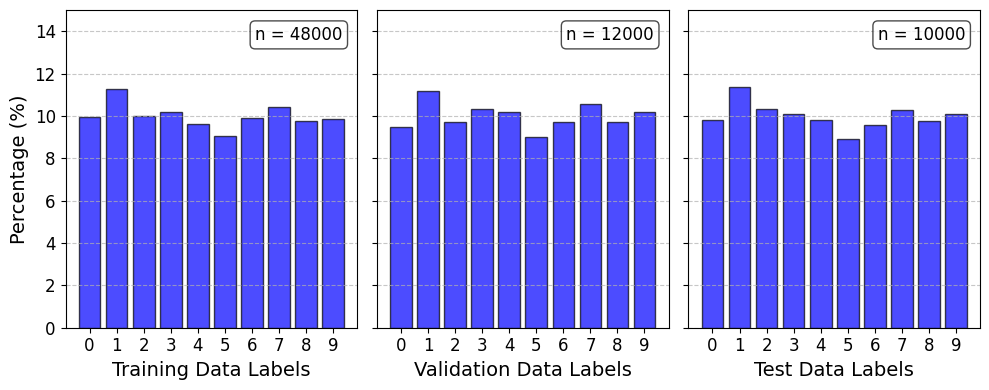

In [4]:
# Print the shape of the initial input data in table and plot distribution 
data_shapes_initial_inputs = pd.DataFrame({
    "Dataset": ["Training", "Validation", "Test"],
    "Features Shape (x)": [x_train.shape, x_val.shape, x_test.shape],
    "Labels Shape (y)": [y_train.shape, y_val.shape, y_test.shape]
})
print(tabulate(data_shapes_initial_inputs, headers='keys', tablefmt='grid'))

# Print a plot of the percentage distribution of the data 
# Calculate percentage distributions
train_label_percentages = np.bincount(y_train) / len(y_train) * 100
val_label_percentages = np.bincount(y_val) / len(y_val) * 100
test_label_percentages = np.bincount(y_test) / len(y_test) * 100

labels = np.arange(num_params)
num_train = len(y_train)
num_val = len(y_val)
num_test = len(y_test)

# Set up the axis
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)

# Training Data Plot
axes[0].bar(labels, train_label_percentages, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel("Training Data Labels", fontsize=14)
axes[0].set_ylabel("Percentage (%)", fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_xticks(labels)
axes[0].set_ylim(0, 15)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].text(0.95, 0.95, f"n = {num_train}", transform=axes[0].transAxes, 
             fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Validation Data Plot
axes[1].bar(labels, val_label_percentages, color='blue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel("Validation Data Labels", fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_xticks(labels)
axes[1].set_ylim(0, 15)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].text(0.95, 0.95, f"n = {num_val}", transform=axes[1].transAxes, 
             fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Test Data Plot
axes[2].bar(labels, test_label_percentages, color='blue', alpha=0.7, edgecolor='black')
axes[2].set_xlabel("Test Data Labels", fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].set_xticks(labels)
axes[2].set_ylim(0, 15)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].text(0.95, 0.95, f"n = {num_test}", transform=axes[2].transAxes, 
             fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Step 2 - Producing Double Digit Datasets

#### 2.1 - Sample with Replacement

- From each of the distributions there are a very large number of unique pairings (permitations - n(n-1) ) to create double digit numbers
- As shown below given the sample size below the chances of exact repeated images is negligible 
- As there is a greater number of way to generate central values from 0-19 then it should form a triangle distribution
- If the end purpose is to classify two randomly generated numbers from single digits then then is the best way as it is trained on a higher preportion of these - this analysis assumes this.
- If the end purpose is to classify a uniform distribution of double digits then the samples with each label value should be truncated to have the same number of samples afterward

    | **Dataset**  | **Size (single-digit images)** | **Possible Unique Images (double-digit)** | **Samples Generated** |
    |--------------|--------------------------------|-------------------------------------------|------------------------|
    | Training     | 48,000                         | 2,303,928,000                             | 100,000               |
    | Validation   | 12,000                         | 132,000,000                               | 1,500                 |
    | Test         | 10,000                         | 90,000,000                                | 1,500                 |

#### 2.2 - V Stack images

- To generate images of desired sizes, `56 X 28` the images must be verticalled stacked

#### 2.3 - Plot distributions of each to show statistical consistency 

- At this stage we look for a trianguluar distribution over all values (0-19) 

In [5]:
# Create v stack input data 
train_double_size = 100000
val_double_size = 15000
test_double_size = 15000

# Generate random indices for the double data set
# Vectorised sampling with replacement
train_double_indices =  [np.random.randint(0, x_train.shape[0], train_double_size), np.random.randint(0, x_train.shape[0], train_double_size)]

val_double_indices =  [np.random.randint(0, x_val.shape[0], val_double_size), np.random.randint(0, x_val.shape[0], val_double_size)]

test_double_indices =  [np.random.randint(0, x_test.shape[0], test_double_size), np.random.randint(0, x_test.shape[0], test_double_size)]


# Generate their corresponding images and labels at these indices

x_train_double = np.concatenate((x_train[train_double_indices[0]], x_train[train_double_indices[1]]), axis=1) 
y_train_double = np.add(y_train[train_double_indices[0]], y_train[train_double_indices[1]])

x_val_double = np.concatenate((x_val[val_double_indices[0]], x_val[val_double_indices[1]]), axis=1)
y_val_double = np.add(y_val[val_double_indices[0]], y_val[val_double_indices[1]])

x_test_double = np.concatenate((x_test[test_double_indices[0]], x_test[test_double_indices[1]]), axis=1)
y_test_double = np.add(y_test[test_double_indices[0]], y_test[test_double_indices[1]])


Item 59383/100000 from x_train
Label: 11


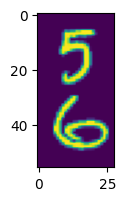

In [6]:
# Print example double data and labels - randomly selected
plot_index_double = np.random.randint(0, len(x_train_double))
print(f"Item {plot_index_double}/{len(x_train_double)} from x_train")
print(f'Label: {y_train_double[plot_index_double]}')
plt.figure(figsize=(2, 2))
plt.imshow(x_train_double[plot_index_double])
plt.show()

+----+------------+----------------------+--------------------+
|    | Dataset    | Features Shape (x)   | Labels Shape (y)   |
+====+============+======================+====================+
|  0 | Training   | (100000, 56, 28)     | (100000,)          |
+----+------------+----------------------+--------------------+
|  1 | Validation | (15000, 56, 28)      | (15000,)           |
+----+------------+----------------------+--------------------+
|  2 | Test       | (15000, 56, 28)      | (15000,)           |
+----+------------+----------------------+--------------------+


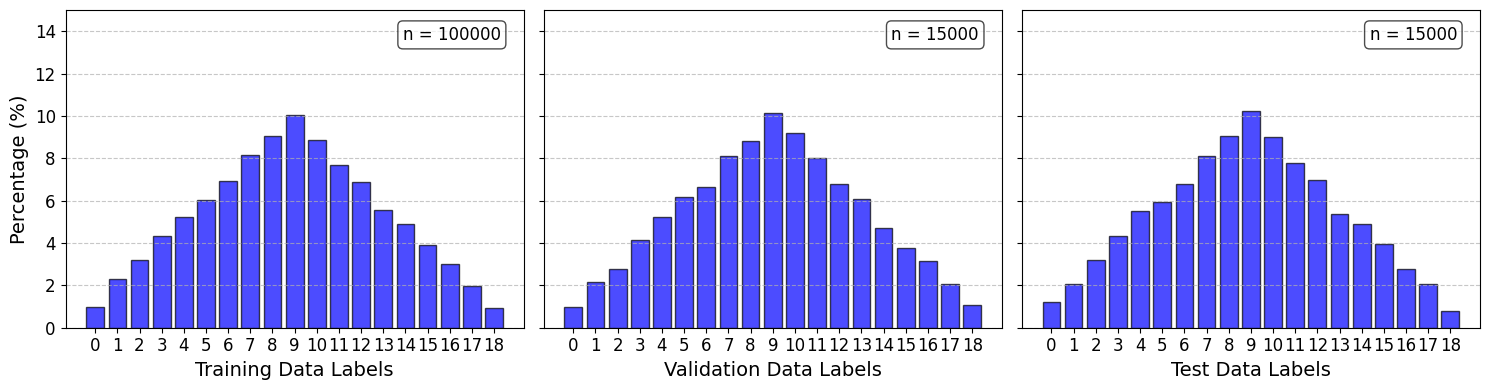

In [7]:
# Print the shape of the double input data in table and plot distribution 
num_params_double = len(np.unique(y_test_double))

# Print the shape of the data in table
data_shapes_double_inputs = pd.DataFrame({
    "Dataset": ["Training", "Validation", "Test"],
    "Features Shape (x)": [x_train_double.shape, x_val_double.shape, x_test_double.shape],
    "Labels Shape (y)": [y_train_double.shape, y_val_double.shape, y_test_double.shape]
})
print(tabulate(data_shapes_double_inputs, headers='keys', tablefmt='grid'))

# Print a plot of the percentage distribution of the data 
# Calculate percentage distributions
train_double_label_percentages = np.bincount(y_train_double) / len(y_train_double) * 100
val_double_label_percentages = np.bincount(y_val_double) / len(y_val_double) * 100
test_double_label_percentages = np.bincount(y_test_double) / len(y_test_double) * 100

labels = np.arange(num_params_double)
num_train_double = len(y_train_double)
num_val_double = len(y_val_double)
num_test_double = len(y_test_double)

# Set up the axis
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Training Data Plot
axes[0].bar(labels, train_double_label_percentages, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel("Training Data Labels", fontsize=14)
axes[0].set_ylabel("Percentage (%)", fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_xticks(labels)
axes[0].set_ylim(0, 15)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].text(0.95, 0.95, f"n = {num_train_double}", transform=axes[0].transAxes, 
             fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Validation Data Plot
axes[1].bar(labels, val_double_label_percentages, color='blue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel("Validation Data Labels", fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_xticks(labels)
axes[1].set_ylim(0, 15)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].text(0.95, 0.95, f"n = {num_val_double}", transform=axes[1].transAxes, 
             fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Test Data Plot
axes[2].bar(labels, test_double_label_percentages, color='blue', alpha=0.7, edgecolor='black')
axes[2].set_xlabel("Test Data Labels", fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].set_xticks(labels)
axes[2].set_ylim(0, 15)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].text(0.95, 0.95, f"n = {num_test_double}", transform=axes[2].transAxes, 
             fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Question 2 - Building and Optimising a Neural Network

### Step 1 - Convert data to categorical labels
- This becomes a **Multi-Class Classification** problem in which images are classifed by the addition of there v stacked digits



In [8]:
# Convert the y labels to categorical labels
print(f"Data label (number): {y_train_double[10]}\n")

y_train_double = to_categorical(y_train_double, num_classes=num_params_double)
y_val_double = to_categorical(y_val_double, num_classes=num_params_double)
y_test_double = to_categorical(y_test_double, num_classes=num_params_double)

print(f"Becomes catagorised: {y_train_double[10]}")

Data label (number): 5

Becomes catagorised: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Step 2 - Optimise the Neural Network Model from 5 Hyperparameters

#### 2.1 Model Certainties
- **Output Activation Function**:  
  - **Softmax** for classifying outputs as probabilities for each class.
- **Depth**:  
  - **Three fully connected dense layers** - previously optimised for - extra layers added no extra accuracy and increased models computational overhead
- **Shape**:  
  - **Funnel architecture**, with the number of neurons decreasing at a constant rate across layers.
- **Batch Normalisation**:  
  - Applied after each dense layer to normalise inputs, stabilise training and improve convergence speed.
- **Input Shape**:  
  - **Flattened 26*28**, the dimensions of each double digit input sample.
- **Output Shape**:  
  - **19**, the number of possible digits/ classes in the dataset.
- **Batch Size**:  
  - **64 samples** per batch for efficient model training.

#### 2.2 - Model Hyperparameters
- **Dropout Rate**:  
  - Method of regularisation to prevent overfitting by randomly deactivating a fraction of neurons during training.  
  - Range: 0.25 to 0.5.
- **Activation Function**:  .  
  - Options: `relu`, `tanh`, `sigmoid`, `swish`.
- **Starting Units**:  
  - The initial number of neurons in the first dense layer.  
  - Range: 600 to 1000 (logarithmic scale).
- **Reduction Factor**:  
  - The reduction rate of neurons from layer to layer, creating a funnel-shaped network.  
  - Range: 0.65 to 0.85.
- **Learning Rate**:  
  - Range: 1e-3 to 6e-3 (logarithmic scale).

#### 2.3 - Optuna
- **Epochs**:  
  - Trained for 7 epochs to give early performance metric.
- **Trains**:  
  - Runs 35 trials of different combinations of hyperparameters to identify the best-performing model.

In [ ]:
input_shape = (x_train_double.shape[1], x_train_double.shape[2])
output_shape = y_train_double.shape[1]
# Optuna optimisation function
def objective(trial):
    # 5 hyperparameters to scan over
    dropout_rate = trial.suggest_float('dropout_rate', 0.25, 0.5)
    starting_units = trial.suggest_int('starting_units', 600, 1000, log=True)  
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 6e-3, log=True)
    reduction_factor = trial.suggest_float('reduction_factor', 0.65, 0.85)  
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'swish'])
    
    # Build the model
    model = Sequential()
    # Flatten the input data
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    
    units = starting_units
    for _ in range(3):
        # Add Dense layer
        model.add(Dense(units=units))
        # Add Batch Normalization
        model.add(BatchNormalization())
        # Add activation separately
        model.add(Activation(activation))
        # Add Dropout for regularization
        model.add(Dropout(rate=dropout_rate))
        # Reduce units for the next layer
        units = int(units * reduction_factor)

    model.add(Dense(output_shape, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(x_train_double, y_train_double, 
                        validation_data=(x_val_double, y_val_double),
                        epochs=7, 
                        batch_size=64, 
                        verbose=0)
    
    # Evaluate the model
    score = model.evaluate(x_test_double, y_test_double, verbose=0)
    accuracy = score[1]
    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name="Double_MNIST_Hyperparamater_Optimisation")

study.optimize(objective, n_trials=35)  

[I 2024-12-10 17:21:41,851] A new study created in memory with name: Double_MNIST_Hyperparamater_Optimisation
2024-12-10 17:21:41.863485: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-10 17:21:41.863513: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-10 17:21:41.863520: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-10 17:21:41.863709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-10 17:21:41.863721: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-12-10 17:21:43.864905: I tensorflow/core/grappler/optimizers/custom_gra

#### 2.4 - Summary of Best Performing model

In [10]:
# Create a table showing the top 6 best trails performed by optuna

# Extract the six best trials from the Optuna study
best_6_trials = study.trials_dataframe().nlargest(6, "value")

# Create a list of dictionaries to hold the trial results
best_6_results = []
for index, row in best_6_trials.iterrows():
    trial = study.trials[int(row['number'])]
    result = {
        'Trial': trial.number,
        'Value': trial.value,
        **trial.params  # Unpack hyperparameters
    }
    best_6_results.append(result)

# Convert to a DataFrame
best_results_df = pd.DataFrame(best_6_results)

# Convert to displayable table
table_best_6_trails = tabulate(best_results_df, headers='keys', tablefmt='grid')
print(table_best_6_trails)

+----+---------+----------+----------------+------------------+-----------------+--------------------+--------------+
|    |   Trial |    Value |   dropout_rate |   starting_units |   learning_rate |   reduction_factor | activation   |
+====+=========+==========+================+==================+=================+====================+==============+
|  0 |      26 | 0.950733 |       0.253743 |              877 |      0.00346275 |           0.709456 | relu         |
+----+---------+----------+----------------+------------------+-----------------+--------------------+--------------+
|  1 |      24 | 0.9478   |       0.250707 |              853 |      0.00312541 |           0.654416 | relu         |
+----+---------+----------+----------------+------------------+-----------------+--------------------+--------------+
|  2 |      19 | 0.9474   |       0.259009 |              705 |      0.00205136 |           0.728661 | relu         |
+----+---------+----------+----------------+------------

### Step 3 - Fully Train Best Performing Model
#### 3.1 Train Model
- The best preforming model is then trained fully (max 20 epochs)
- **Early stopping** is applied to stop overfitting 

In [12]:
# Build the best model over 20 epochs - with early stopping

# Extract the best parameters from optuna study
best_params = study.best_trial.params

activation = best_params['activation']
dropout_rate = best_params['dropout_rate']
starting_units = best_params['starting_units']
learning_rate = best_params['learning_rate']
reduction_factor = best_params['reduction_factor']

    
# Build the model
model_best = Sequential()
model_best.add(Input(shape=input_shape))
model_best.add(Flatten())

units = starting_units
for _ in range(3):
    model_best.add(Dense(units=units, kernel_regularizer=None))
    model_best.add(BatchNormalization())  
    model_best.add(Activation(activation))
    model_best.add(Dropout(rate=dropout_rate))
    units = int(units * reduction_factor)

model_best.add(Dense(output_shape, activation='softmax'))
    
# Compile the model
model_best.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         
    patience=3,                
    restore_best_weights=True 
)

# Train the 'best' model for 20 epoch
history_best = model_best.fit(
    x_train_double, y_train_double,
    validation_data=(x_val_double, y_val_double),
    epochs=20,
    callbacks=[early_stopping], # Add the early stopping callback
    batch_size=64,
    verbose=1
)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.5634 - loss: 1.3885 - val_accuracy: 0.8686 - val_loss: 0.4576
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.8634 - loss: 0.4601 - val_accuracy: 0.9045 - val_loss: 0.3395
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.9022 - loss: 0.3273 - val_accuracy: 0.9205 - val_loss: 0.2815
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.9255 - loss: 0.2515 - val_accuracy: 0.9297 - val_loss: 0.2596
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.9370 - loss: 0.2119 - val_accuracy: 0.9342 - val_loss: 0.2515
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.9453 - loss: 0.1817 - val_accuracy: 0.9343 - val_loss: 0.2585
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.9528 - loss: 0.1561 - val_accuracy: 0.9382 - val_loss: 0.2534
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.9591 -

#### 3.2 - Save Model
The model is the saved in `Results` Directory for reproducability
1. Full Model: `Results/mnist_double_best_model.keras`
2. Model's Weights: `Results/mnist_double_best_model_weights.weights.h`
3. Training History: `Results/mnist_double_best_model_training_history.json`

In [15]:
# Save the results of best model in a Results folder - for reproducibility
# Save the whole model
model_best.save('Results/mnist_double_best_model.keras')

# Save just the weights
model_best.save_weights('Results/mnist_double_best_model_weights.weights.h5') 

# Save the training history as a JSON file
json.dump(history_best.history, open('Results/mnist_double_best_model_training_history.json', 'w'))

#### 3.3 - Model Tested for Unseen Data Performance
- Model is reloaded
- Evaluated for accuracy against Test data set

In [16]:
# Load back the model and evaluate it - for reproducibility
model_best_file = tf.keras.models.load_model('Results/mnist_double_best_model.keras')

score = model_best_file.evaluate(x_test_double, y_test_double, verbose=1)
print(f"Test Accuracy: {score[1]}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9412 - loss: 0.2105
Test Accuracy: 0.9411333203315735


### Model Summary

In [17]:
# print the 'best models' summary
model_best_file.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_35 (Flatten)            │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 877)            │     1,376,013 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 877)            │         3,508 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_105 (Activation)     │ (None, 877)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 877)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 622)            │       546,116 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 622)            │         2,488 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_106 (Activation)     │ (None, 622)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 622)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 441)            │       274,743 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 441)            │         1,764 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_107 (Activation)     │ (None, 441)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 441)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 19)             │         8,398 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,631,332 (25.30 MB)

 Trainable params: 2,209,150 (8.43 MB)

 Non-trainable params: 3,880 (15.16 KB)

 Optimizer params: 4,418,302 (16.85 MB)

### Training History for Training and Validation Data set

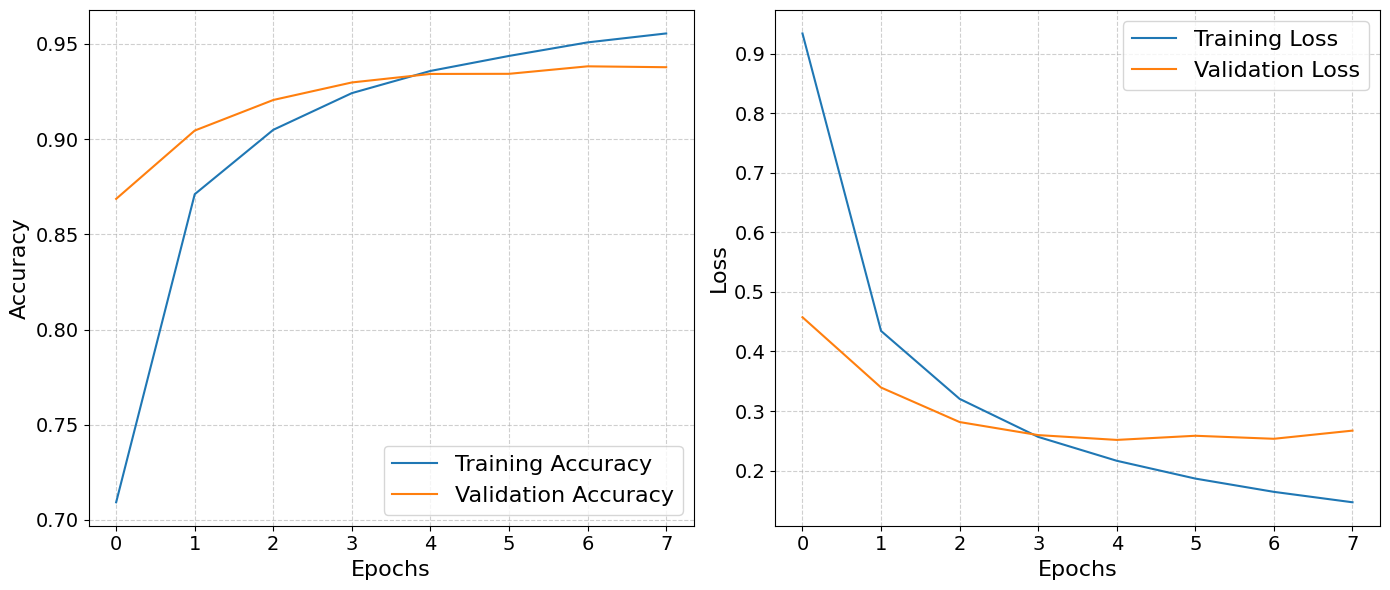

In [18]:
# Load the history from the saved JSON file
history_best_file = json.load(open('Results/mnist_double_best_model_training_history.json', 'r'))

font_size = 16
tick_size = 14
title_size = 18
fig_size = (14, 6)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=fig_size) 

# Plot Training and Validation Accuracy against epochs
axes[0].plot(history_best_file['accuracy'], label='Training Accuracy')
axes[0].plot(history_best_file['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epochs', fontsize=font_size)
axes[0].set_ylabel('Accuracy', fontsize=font_size)
axes[0].legend(fontsize=font_size)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].tick_params(axis='both', which='major', labelsize=tick_size)

# Plot Training and Validation Loss against epochs
axes[1].plot(history_best_file['loss'], label='Training Loss')
axes[1].plot(history_best_file['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epochs', fontsize=font_size)
axes[1].set_ylabel('Loss', fontsize=font_size)
axes[1].legend(fontsize=font_size)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].tick_params(axis='both', which='major', labelsize=tick_size)

plt.tight_layout()
plt.show()